In [17]:
import pandas as pd
import datetime as dt
import matplotlib
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
plt.style.use('bmh')
matplotlib.rcParams['figure.figsize'] = (10, 4)
import warnings
warnings.filterwarnings('ignore')

### 读取数据, 训练集验证集分离

In [18]:
def myparser(date): return dt.datetime.strptime(date, "%Y-%m-%d")


data = pd.read_csv('milk_production.csv',
                   index_col='date',
                   parse_dates=['date'], date_parser=myparser)
data.index.freq = 'MS'

whole = data
data = data[:-12]
data_test = data[-12:]
print(len(data), '\n', len(data_test))

156 
 12


### 平稳性检验

In [19]:
def test_stationarity(ts):
    
    # Augmented Dickey-Fuller test:
    from statsmodels.tsa.stattools import adfuller
    adf = adfuller(ts, autolag='AIC')
    output = pd.Series(adf[0:4], 
                       index=['Test Statistic','p-value',
                              'Lags Used','Num of Observations Used'])
    
    
    # 移动统计量
    rolmean = pd.Series.rolling(ts, window=12).mean()
    rolstd = pd.Series.rolling(ts, window=12).std()
    
    fig, ax1 = plt.subplots()
    # 双轴(共享x轴)
    ax2 = ax1.twinx()  

    ax1.plot(ts, label='Time Series', color='blue')
    ax1.plot(rolmean, label='RolMean_12p', color='red')
    ax1.set_ylabel('pounds_per_cow')

    ax2.plot(rolstd, label='RolStd_12p',
             color='gray', alpha=.5, ls='--')  # ls: linestyle

    ax2.set_ylabel('Std')
    ax2.tick_params(axis='y')
    ax2.grid(False)
    
    # 图例
    h1, lab1 = ax1.get_legend_handles_labels()
    h2, lab2 = ax2.get_legend_handles_labels()
    handles = h1 + h2
    labels = lab1 + lab2

    plt.legend(handles, labels, loc='upper left')    
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print('Results of Dickey-Fuller Test:')
    for key,value in adf[4].items():
        output['Critical Value (%s)'.format(key)] = value
    print(output)   

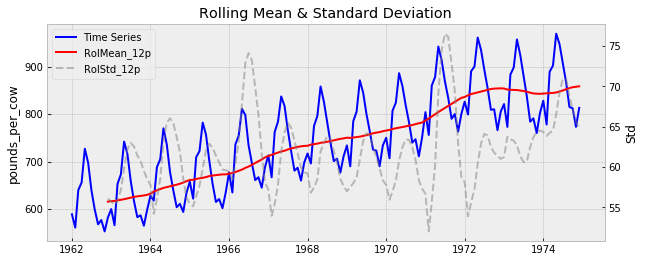

Results of Dickey-Fuller Test:
Test Statistic               -1.291398
p-value                       0.633099
Lags Used                    13.000000
Num of Observations Used    142.000000
Critical Value (%s)          -2.577743
dtype: float64

移动平均和移动标准差都不稳定呈现向上的趋势，并且时间序列没有通过Dickey-Fuller检验表明时间序列不稳定。


In [20]:
test_stationarity(data)
print('\n移动平均和移动标准差都不稳定呈现向上的趋势，并且时间序列没有通过Dickey-Fuller检验表明时间序列不稳定。')

### 时间序列变换

#### 分解

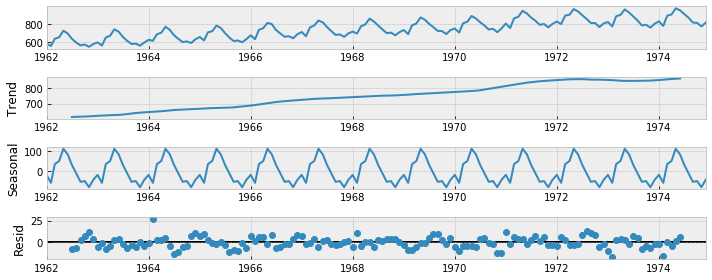


通过分解时间序列可以明显发现其趋势性和季节性的特征，其季节性以12个月为一个周期。


In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(data, period=12)
decomposed.plot()
plt.show()
print('\n通过分解时间序列可以明显发现其趋势性和季节性的特征，其季节性以12个月为一个周期。')

#### 差分

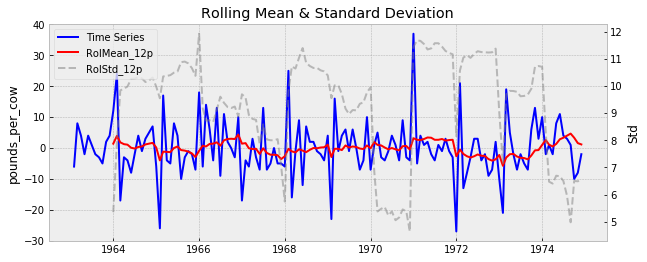

Results of Dickey-Fuller Test:
Test Statistic               -4.263156
p-value                       0.000514
Lags Used                    11.000000
Num of Observations Used    131.000000
Critical Value (%s)          -2.578677
dtype: float64

通过两次差分将时间序列的趋势性和季节性去除使时间序列变平稳，同时Dickey-Fuller检验结果也表明时间序列已经平稳。


In [22]:
data_diff = data.diff().diff(12).dropna()
test_stationarity(data_diff)
print('\n通过两次差分将时间序列的趋势性和季节性去除使时间序列变平稳，同时Dickey-Fuller检验结果也表明时间序列已经平稳。')

### 确定模型参数

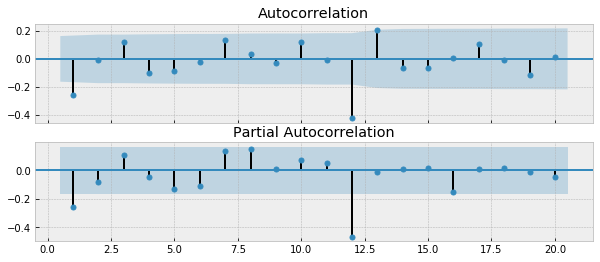

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(nrows=2, sharex=True)

plot_acf(data_diff, ax=ax[0], zero=False, lags=20)
plot_pacf(data_diff, ax=ax[1], zero=False, lags=20)
plt.show()

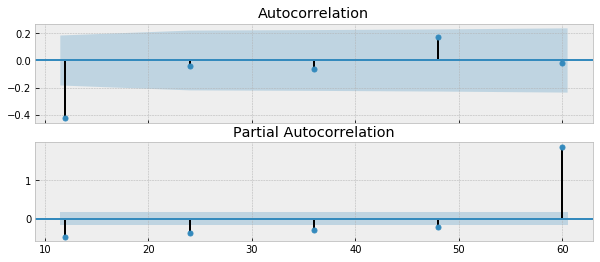

In [24]:
lags = [12, 24, 36, 48, 60]

fig, ax = plt.subplots(nrows=2, sharex=True)

plot_acf(data_diff, lags=lags, ax=ax[0], zero=False)
plot_pacf(data_diff, lags=lags, ax=ax[1], zero=False)

plt.show()

### 建模与评估

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(whole, order=(0,1,1), seasonal_order=(0,1,1,12))

results = model.fit()

                                     SARIMAX Results                                      
Dep. Variable:                     pounds_per_cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -530.148
Date:                            Sat, 13 Jun 2020   AIC                           1066.296
Time:                                    11:59:13   BIC                           1075.427
Sample:                                01-01-1962   HQIC                          1070.005
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2204      0.076     -2.898      0.004      -0.369      -0.071
ma.S.L12      -0.6214      0.070   

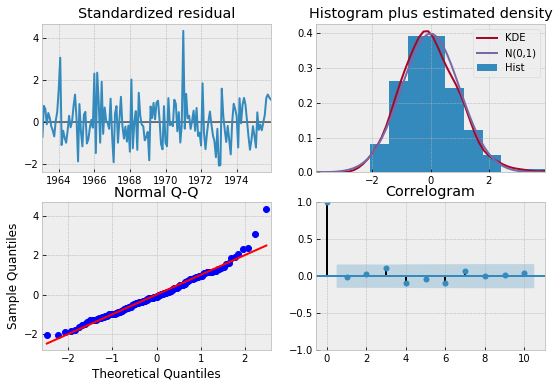

In [26]:
print(results.summary())
results.plot_diagnostics(figsize=(9, 6))
plt.show()

### 预测

In [27]:
dynamic_forecast = results.get_prediction(start=-24, dynamic=True)

mean_forecast = dynamic_forecast.predicted_mean
conf_intervals = dynamic_forecast.conf_int()

lower_limits = conf_intervals.loc[:,'lower pounds_per_cow']
upper_limits = conf_intervals.loc[:,'upper pounds_per_cow']

print(mean_forecast)

date
1974-01-01    825.971786
1974-02-01    785.111896
1974-03-01    885.842967
1974-04-01    901.006088
1974-05-01    961.931141
1974-06-01    932.791634
1974-07-01    889.624211
1974-08-01    849.333401
1974-09-01    802.366648
1974-10-01    807.764959
1974-11-01    772.787120
1974-12-01    812.757613
1975-01-01    837.370682
1975-02-01    796.510791
1975-03-01    897.241862
1975-04-01    912.404984
1975-05-01    973.330037
1975-06-01    944.190530
1975-07-01    901.023107
1975-08-01    860.732297
1975-09-01    813.765544
1975-10-01    819.163855
1975-11-01    784.186016
1975-12-01    824.156508
Freq: MS, dtype: float64


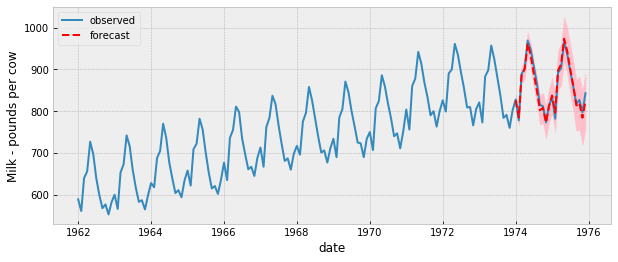

In [28]:
plt.plot(whole.index, whole.values, label='observed')


plt.plot(mean_forecast.index, mean_forecast.values,
         color='r', label='forecast', ls='--')

plt.fill_between(mean_forecast.index, lower_limits,
                 upper_limits, color='pink')

plt.xlabel('date')
plt.ylabel('Milk - pounds per cow')
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error 
mean_squared_error(data[-24:], mean_forecast)

101.5817757814098

In [30]:
np.mean(np.abs(np.array(data[-24:]) - np.array(mean_forecast)) / np.array(data[-24:])) * 100

8.190792814842183